In [1]:
now...
import tensorflow as tf

In [2]:
from utils_052621_tf2_github import *

In [3]:
# import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

prefix = 'D:/Dropbox (Partners Healthcare)/'
datafolder = prefix+'profile_2021/derived_data/curate_all/'
modelfolder = prefix+'profile_2021/derived_data/curate_all/models/medonc'

In [4]:
# read dataset into Pandas (pd)
# Load labeled data. Columns any_cancer, adrenal, bone, brain, liver, lung, nodes, peritoneum, pleura, response, progression represent gold standard labels. We did not train models to identify disease in lung or pleura (local disease sites for lung cancer) in this analysis.
# read dataset into Pandas (pd)
label_analysis = pd.read_csv(datafolder+ 'labeled_medonc.csv')
print(label_analysis.info())
label_analysis['text'] = label_analysis['ap_inferred']
print(label_analysis.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32512 entries, 0 to 32511
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                32512 non-null  int64  
 1   dfci_mrn                  32512 non-null  float64
 2   cancer_type               32512 non-null  object 
 3   date                      32512 non-null  object 
 4   any_cancer                32512 non-null  int64  
 5   progression               32512 non-null  int64  
 6   response                  32512 non-null  int64  
 7   Unnamed: 0.1              32512 non-null  int64  
 8   Unnamed: 0.1.1            32512 non-null  int64  
 9   Unnamed: 0.1.1.1          32512 non-null  int64  
 10  text                      32512 non-null  object 
 11  new_rx_30d                32512 non-null  float64
 12  died_90d                  32512 non-null  int64  
 13  died_180d                 32512 non-null  int64  
 14  died_2

In [ ]:
train_data = label_analysis[label_analysis.split=='train']
valid_data = label_analysis[label_analysis.split=='validation']
test_data = label_analysis[label_analysis.split=='test']


training_patients = train_data.dfci_mrn.unique()
np.random.seed(43)
np.random.shuffle(training_patients)
splits = np.array_split(training_patients, 10)


In [6]:
# how many notes were labeled as indicating any cancer 
print(train_data.any_cancer.value_counts())

1    20858
0     5902
Name: any_cancer, dtype: int64


In [7]:
# how many notes were labeled as indicating response/improving cancer 
print(train_data.response.value_counts())

0    23618
1     3142
Name: response, dtype: int64


In [8]:
# # how many notes were labeled as indicating progression/worsening cancer
print(train_data.progression.value_counts())

0    22562
1     4198
Name: progression, dtype: int64


In [9]:
train_tokenizer = False
vocab_size = 1000
max_note_length = 750

In [10]:
# set up datasets for training
# this method requires a 'tokenizer' to turn unique words into unique numbers
if train_tokenizer:
    tokenizer = Tokenizer(num_words = vocab_size)
    tokenizer.fit_on_texts([str(x) for x in train_data['text']])
    with open(modelfolder+'/notes_tokenizer_ap_find.pickle', 'wb') as handle:
         pickle.dump(tokenizer, handle, protocol=3)


In [11]:
# load tokenizer if already trained
with open(modelfolder+'/notes_tokenizer_ap_find.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    

In [12]:
# ML imports
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, concatenate, Average
from tensorflow.keras.layers import Embedding
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, LSTM, TimeDistributed, GRU, Bidirectional, Layer
from tensorflow.keras import backend as K


In [13]:
# set up deep learning model
max_note_length = 750

def get_simple_model(target):
    vocab_size = 10000
    embedding_dims = 300
    filters = 300
    kernel_size = 10
    epochs = 2
    hidden_dims = 250
    max_note_length=750
    batch_size = 32


    # make model
    text_input = Input(shape=(max_note_length,), dtype='float32')



    text_embed = Embedding(vocab_size, embedding_dims, input_length=max_note_length, mask_zero=False)(text_input)
    #text_embed = Dropout(0.5)(text_embed)

    
    cnn1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='valid')(text_embed)
    x = GlobalMaxPooling1D()(cnn1)
    
    
    hidden = Dense(hidden_dims)(x)
    hidden = Activation('relu')(hidden)
    
    anycancer_hidden = Dense(hidden_dims)(x)
    anycancer_out = Dense(1, activation='linear')(anycancer_hidden)
    
    if target == 'any_cancer':
        model = Model(inputs=text_input, outputs=anycancer_out)
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    else:
        x = concatenate([hidden, anycancer_hidden])
        target_hidden = Dense(hidden_dims)(x)
        target_out = Dense(1, activation='linear')(target_hidden)
        model = Model(inputs=text_input, outputs=[target_out, anycancer_out])
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

    return model



In [15]:
dummy_model = get_simple_model('any_cancer')
print(dummy_model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 750, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 741, 300)          900300    
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               75250     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 3,975,801
Trainable params: 3,975,801
Non-trainable params: 0
___________________________________________________

In [16]:
train_data.cancer_type.value_counts()

prostate        5238
breast          5134
crc             4810
nsclc           4237
pancreas        3424
rcc_barkouny    3116
bladder_xu       801
Name: cancer_type, dtype: int64

In [17]:
train_models = False

train_histologies = ['nsclc','breast','crc','prostate','pancreas','bladder_xu','rcc_barkouny']
extra_model_label = ''



In [19]:
x_text_valid = sequence.pad_sequences(tokenizer.texts_to_sequences([str(x) for x in valid_data['text']]), maxlen=max_note_length, padding='post')
prediction_set = []


pd.set_option('mode.chained_assignment', None)


# cross validation model training and inference

for i in range(10):

    thissplit_data = train_data[(~train_data.dfci_mrn.isin(splits[i])) & (train_data.cancer_type.isin(train_histologies))]
    prediction_split = train_data[train_data.dfci_mrn.isin(splits[i])]
    prediction_split['label_split'] = 'train_' + str(i)
    
    x_text_train = sequence.pad_sequences(tokenizer.texts_to_sequences([str(x) for x in thissplit_data['text']]), maxlen=max_note_length, padding='post')
    text_predict = sequence.pad_sequences(tokenizer.texts_to_sequences([str(x) for x in prediction_split['text']]), maxlen=max_note_length, padding='post')

    for j in ['any_cancer', 'progression', 'response']:
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=modelfolder + '/' + j+str(i)+extra_model_label+'.h5',
                save_best_only=False,
                save_weights_only=True,
                monitor='val_loss',
                verbose=0),

        ]

        this_model = get_simple_model(j)
        
        if train_models:
            if j == 'any_cancer':
                this_model.fit(x_text_train, thissplit_data[j].values,
                         validation_data=(x_text_valid, valid_data[j].values),
                         epochs=2,
                         batch_size = 32, verbose = 0, use_multiprocessing=True, callbacks=callbacks)
            else:
                this_model.fit(x_text_train, [thissplit_data[j].values, thissplit_data['any_cancer'].values],
                         validation_data=(x_text_valid, [valid_data[j].values, valid_data['any_cancer'].values]),
                         epochs=2,
                         batch_size = 32, verbose = 0, use_multiprocessing=True, callbacks=callbacks)            

        this_model.load_weights(modelfolder + '/' + j+str(i)+extra_model_label+'.h5')
        
        if j== 'any_cancer':
            prediction_split['cv_'+j+'_prediction'] = this_model.predict(text_predict)
        else:
            prediction_split['cv_'+j+'_prediction'] = this_model.predict(text_predict)[0]
            
        
    
    prediction_set.append(prediction_split)
    

In [20]:
def get_ensemble_model(outcome):
    model_list = []
    predictions = []
    ensemble_input = Input(shape=(max_note_length,), dtype='float32')
    for i in range(10):
        thismod = get_simple_model(outcome)
        thismod.load_weights(modelfolder+'/'+outcome+str(i)+extra_model_label+'.h5')
        model_list.append(thismod)
    
    for i in range(10):
        if outcome=='any_cancer':
            predictions.append(model_list[i](ensemble_input))
        else:
            predictions.append(model_list[i](ensemble_input)[0])

    
    output = Average()(predictions)
    #output = Activation('sigmoid')(output)
    model = Model(inputs = ensemble_input, outputs = output)
    model.save_weights(modelfolder + '/' + 'ensemble_'+outcome+extra_model_label+'.h5')
    return model
    
    
    
    

In [21]:
dummy_ensemble = get_ensemble_model('progression')
dummy_ensemble.summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 750)]        0                                            
__________________________________________________________________________________________________
model_31 (Functional)           [(None, 1), (None, 1 4176552     input_32[0][0]                   
__________________________________________________________________________________________________
model_32 (Functional)           [(None, 1), (None, 1 4176552     input_32[0][0]                   
__________________________________________________________________________________________________
model_33 (Functional)           [(None, 1), (None, 1 4176552     input_32[0][0]                   
___________________________________________________________________________________________

In [22]:
# apply ensemble model to validation set data to evaluate it
x_text_valid = sequence.pad_sequences(tokenizer.texts_to_sequences([str(x) for x in valid_data['text']]), maxlen=max_note_length, padding='post')

prediction_split = valid_data
prediction_split['label_split'] = 'valid'

for j in ['any_cancer', 'progression', 'response']:
    this_model = get_ensemble_model(j)
    prediction_split['cv_'+j+'_prediction'] = this_model.predict(x_text_valid)

prediction_set.append(prediction_split)
    

In [23]:
# do test set here, same as above
x_text_test = sequence.pad_sequences(tokenizer.texts_to_sequences([str(x) for x in test_data['text']]), maxlen=max_note_length, padding='post')

prediction_split = test_data
prediction_split['label_split'] = 'test'

for j in ['any_cancer', 'progression', 'response']:
    this_model = get_ensemble_model(j)
    prediction_split['cv_'+j+'_prediction'] = this_model.predict(x_text_test)

prediction_set.append(prediction_split)

In [ ]:

output = pd.concat(prediction_set, axis=0).reset_index(drop=True)


In [25]:
print(output.shape[0])
print(output.any_cancer.value_counts())
print(output.response.value_counts())
print(output.progression.value_counts())
print(len(output.dfci_mrn.unique()))

32512
1    25488
0     7024
Name: any_cancer, dtype: int64
0    28714
1     3798
Name: response, dtype: int64
0    27360
1     5152
Name: progression, dtype: int64
2767


In [26]:
output.cv_progression_prediction.isnull().value_counts()

False    32512
Name: cv_progression_prediction, dtype: int64

In [27]:
%matplotlib inline

In [28]:
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve




def eval_outcome(dataset, outcome, cancer_type_list, graph=False):
    print('outcome: ' + outcome)
    print('all cancer types')
    best_f1_thresh = eval_model(dataset['cv_'+outcome+'_prediction'], dataset[outcome], graph)
    #print('AUC: ' + str(roc_auc_score(dataset[outcome], dataset['cv_'+outcome+'_prediction'])))
    
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines
    import matplotlib.transforms as mtransforms

    y_plot, x_plot = calibration_curve(dataset[outcome], (np.exp(dataset['cv_'+outcome+'_prediction']) / (1 + np.exp(dataset['cv_'+outcome+'_prediction']))), n_bins=15)

    fig, ax = plt.subplots()
    # only these two lines are calibration curves
    plt.plot(x_plot, y_plot, marker='o', linewidth=1, label=outcome)
    #plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')

    # reference line, legends, and axis labels
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    fig.suptitle('Calibration plot')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability in each bin')
    plt.legend()
    plt.show()
    
    for cancer_type in cancer_type_list:
        print("\n")
        print('outcome: ' + outcome)
        print(cancer_type)
        subset = dataset[(dataset.cancer_type==cancer_type)]
        print(eval_model(subset['cv_'+outcome+'_prediction'], subset[outcome], graph))
        
        import matplotlib.pyplot as plt
        import matplotlib.lines as mlines
        import matplotlib.transforms as mtransforms

        y_plot, x_plot = calibration_curve(subset[outcome], (np.exp(subset['cv_'+outcome+'_prediction']) / (1 + np.exp(subset['cv_'+outcome+'_prediction']))), n_bins=15)

        fig, ax = plt.subplots()
        # only these two lines are calibration curves
        plt.plot(x_plot, y_plot, marker='o', linewidth=1, label=outcome)
        #plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')

        # reference line, legends, and axis labels
        line = mlines.Line2D([0, 1], [0, 1], color='black')
        transform = ax.transAxes
        line.set_transform(transform)
        ax.add_line(line)
        fig.suptitle('Calibration plot')
        ax.set_xlabel('Predicted probability')
        ax.set_ylabel('True probability in each bin')
        plt.legend()
        plt.show()
        
    return best_f1_thresh

In [29]:
output.split.value_counts()

train         26760
validation     2934
test           2818
Name: split, dtype: int64

outcome: any_cancer
all cancer types
AUC 0.9324982830742335
Outcome probability: 0.7977288857345636
Average precision score: 0.98
Best F1: 0.9424585876198779


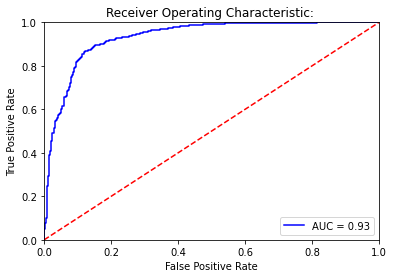

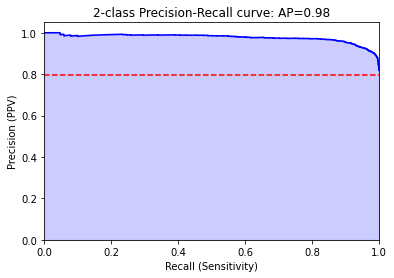

Threshold for best F1:
0.363617
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[ 392  178]
 [  86 2162]]


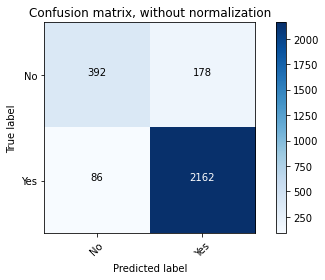

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.82      0.69      0.75       570
         Yes       0.92      0.96      0.94      2248

    accuracy                           0.91      2818
   macro avg       0.87      0.82      0.85      2818
weighted avg       0.90      0.91      0.90      2818

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[ 395  175]
 [  96 2152]]


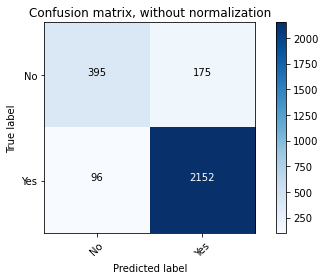

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.80      0.69      0.74       570
         Yes       0.92      0.96      0.94      2248

    accuracy                           0.90      2818
   macro avg       0.86      0.83      0.84      2818
weighted avg       0.90      0.90      0.90      2818



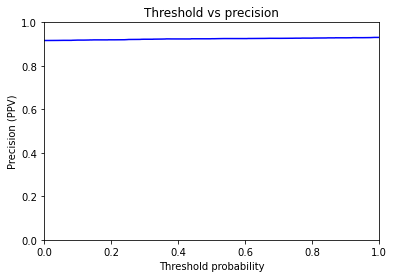

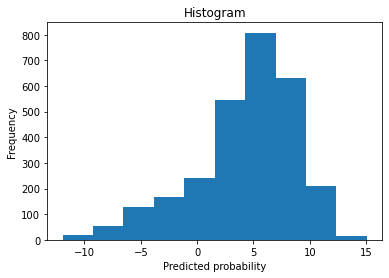

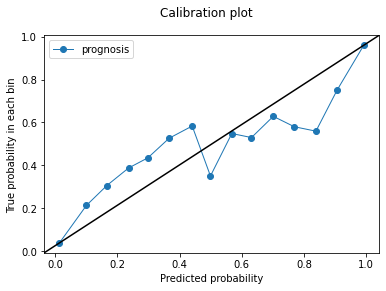



outcome: any_cancer
nsclc
AUC 0.9517222105777964
Outcome probability: 0.7582644628099173
Average precision score: 0.98
Best F1: 0.9325997248968363


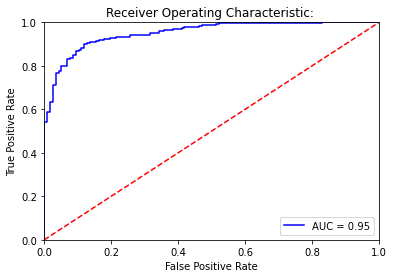

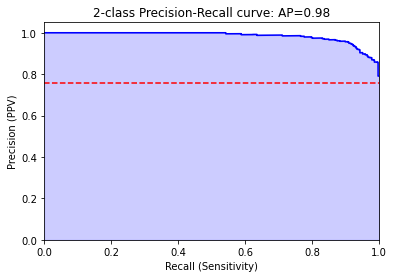

Threshold for best F1:
1.208607
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[ 96  21]
 [ 28 339]]


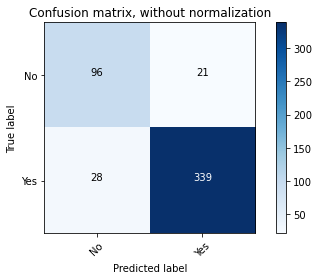

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.77      0.82      0.80       117
         Yes       0.94      0.92      0.93       367

    accuracy                           0.90       484
   macro avg       0.86      0.87      0.86       484
weighted avg       0.90      0.90      0.90       484

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[ 90  27]
 [ 25 342]]


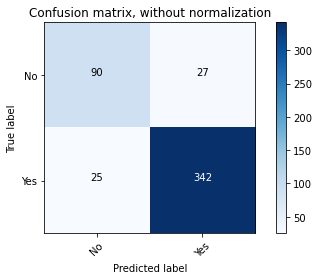

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.78      0.77      0.78       117
         Yes       0.93      0.93      0.93       367

    accuracy                           0.89       484
   macro avg       0.85      0.85      0.85       484
weighted avg       0.89      0.89      0.89       484



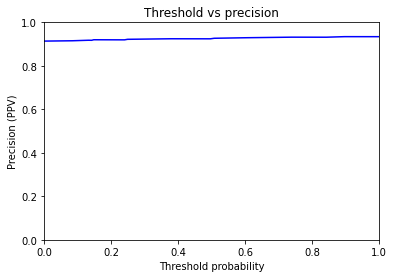

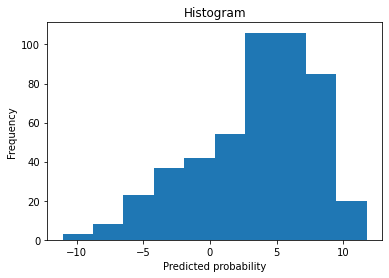

1.208607


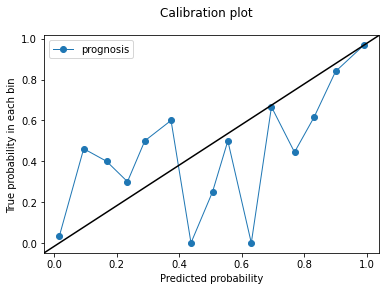

In [30]:
cancer_type_list = ['nsclc']
cutoffs = {}
cutoffs['any_cancer'] = eval_outcome(output[output.split=='test'], 'any_cancer', cancer_type_list, graph=True)

outcome: progression
all cancer types
AUC 0.9222156531531532
Outcome probability: 0.1596877217885025
Average precision score: 0.73
Best F1: 0.6899879372738238


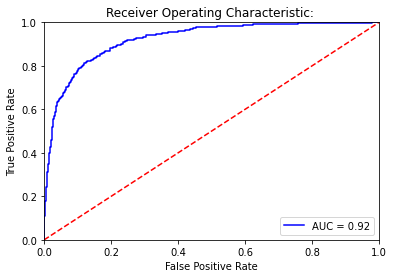

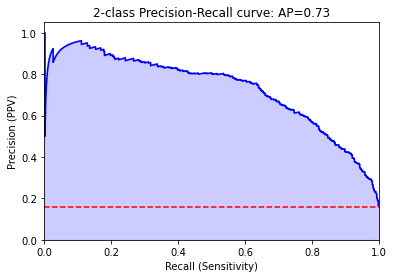

Threshold for best F1:
0.029527878
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2275   93]
 [ 164  286]]


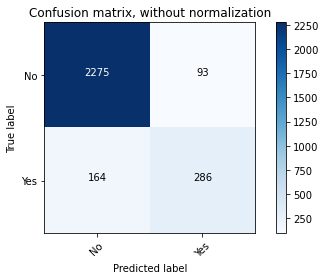

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.93      0.96      0.95      2368
         Yes       0.75      0.64      0.69       450

    accuracy                           0.91      2818
   macro avg       0.84      0.80      0.82      2818
weighted avg       0.90      0.91      0.91      2818

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2304   64]
 [ 204  246]]


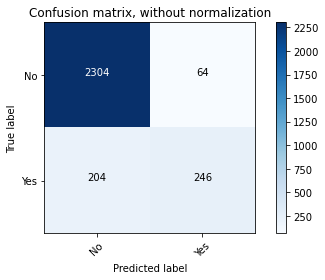

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.92      0.97      0.95      2368
         Yes       0.79      0.55      0.65       450

    accuracy                           0.90      2818
   macro avg       0.86      0.76      0.80      2818
weighted avg       0.90      0.90      0.90      2818



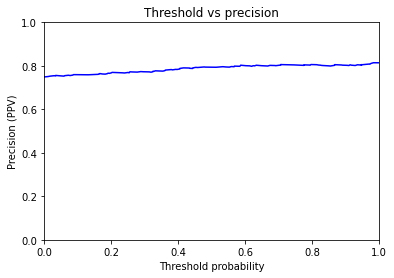

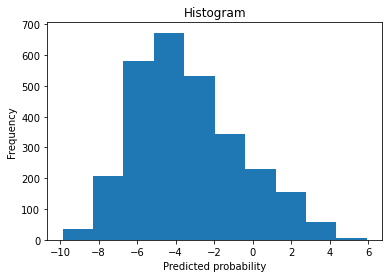

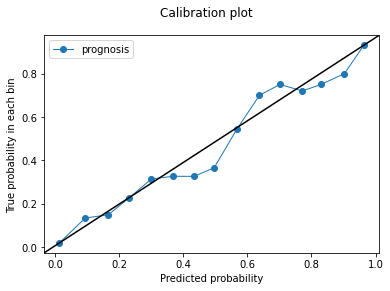



outcome: progression
nsclc
AUC 0.9614002669130479
Outcome probability: 0.21074380165289255
Average precision score: 0.90
Best F1: 0.8241206030150755


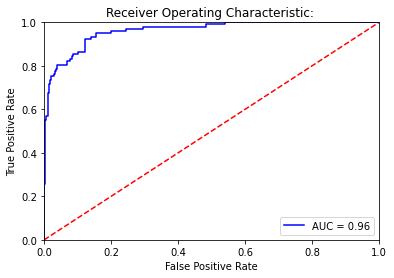

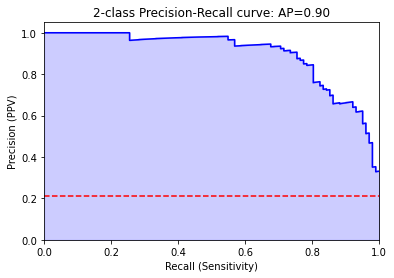

Threshold for best F1:
-0.09653972
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[367  15]
 [ 20  82]]


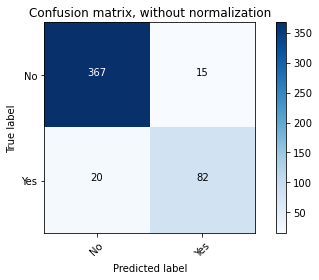

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.95      0.96      0.95       382
         Yes       0.85      0.80      0.82       102

    accuracy                           0.93       484
   macro avg       0.90      0.88      0.89       484
weighted avg       0.93      0.93      0.93       484

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[374   8]
 [ 25  77]]


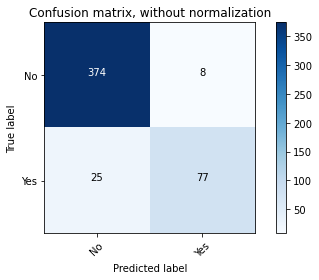

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.94      0.98      0.96       382
         Yes       0.91      0.75      0.82       102

    accuracy                           0.93       484
   macro avg       0.92      0.87      0.89       484
weighted avg       0.93      0.93      0.93       484



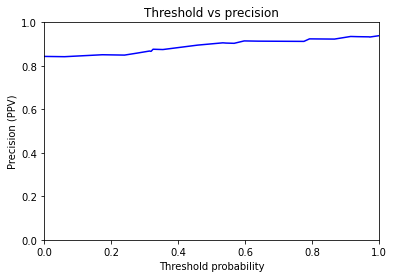

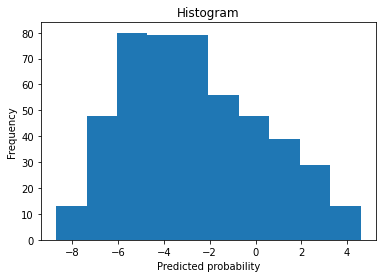

-0.09653972


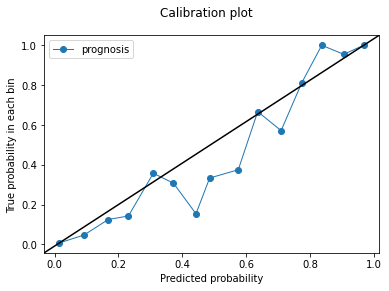

In [31]:
cutoffs['progression'] = eval_outcome(output[output.split=='test'], 'progression', cancer_type_list, graph=True)

outcome: response
all cancer types
AUC 0.9320316201985964
Outcome probability: 0.10681334279630944
Average precision score: 0.71
Best F1: 0.6787003610108304


d:\Dropbox (Partners HealthCare)\profile_2021\code\cross_histol_nlp\medonc\utils_052621_tf2.py:106: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2*((precision*recall)/(precision+recall))


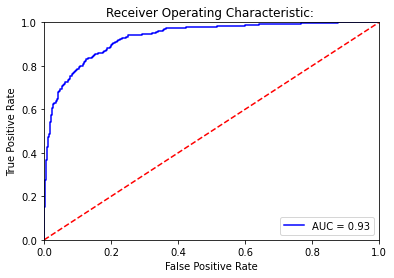

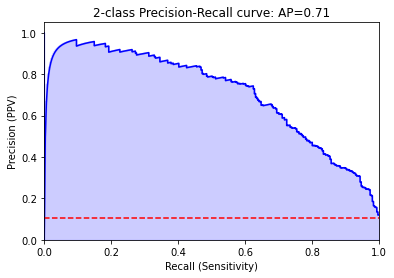

Threshold for best F1:
4.465756
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2516    1]
 [ 301    0]]


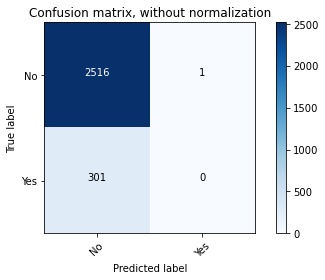

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.89      1.00      0.94      2517
         Yes       0.00      0.00      0.00       301

    accuracy                           0.89      2818
   macro avg       0.45      0.50      0.47      2818
weighted avg       0.80      0.89      0.84      2818

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2493   24]
 [ 175  126]]


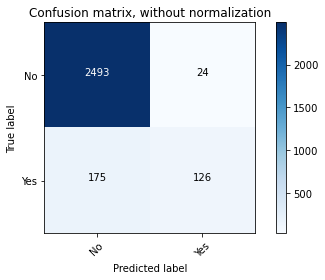

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.93      0.99      0.96      2517
         Yes       0.84      0.42      0.56       301

    accuracy                           0.93      2818
   macro avg       0.89      0.70      0.76      2818
weighted avg       0.92      0.93      0.92      2818



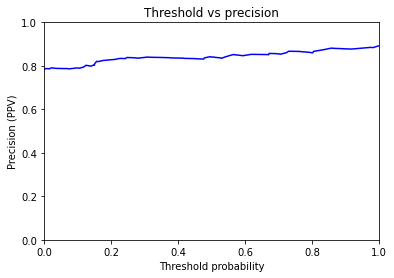

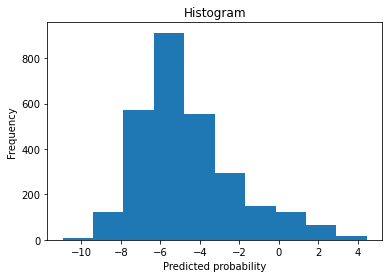

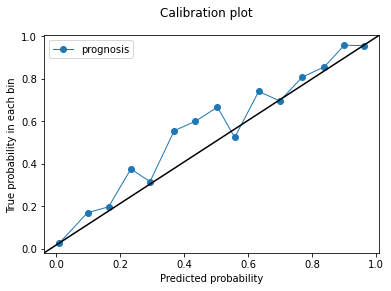



outcome: response
nsclc
AUC 0.9500659195781146
Outcome probability: 0.15289256198347106
Average precision score: 0.86
Best F1: 0.7777777777777778


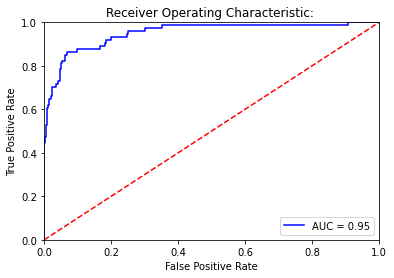

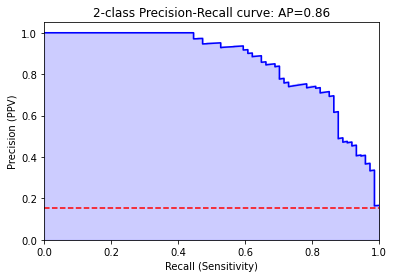

Threshold for best F1:
-2.1916468
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[385  25]
 [ 11  63]]


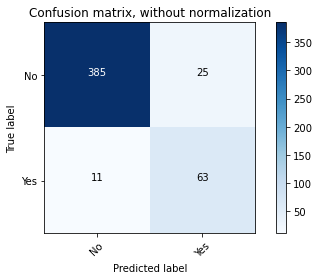

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.97      0.94      0.96       410
         Yes       0.72      0.85      0.78        74

    accuracy                           0.93       484
   macro avg       0.84      0.90      0.87       484
weighted avg       0.93      0.93      0.93       484

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[407   3]
 [ 35  39]]


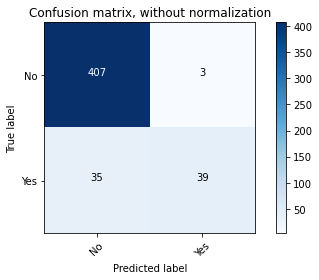

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.92      0.99      0.96       410
         Yes       0.93      0.53      0.67        74

    accuracy                           0.92       484
   macro avg       0.92      0.76      0.81       484
weighted avg       0.92      0.92      0.91       484



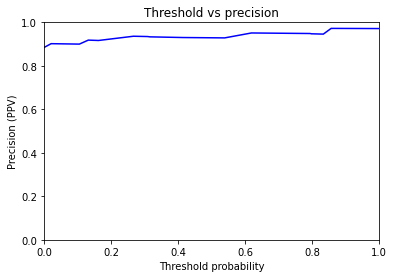

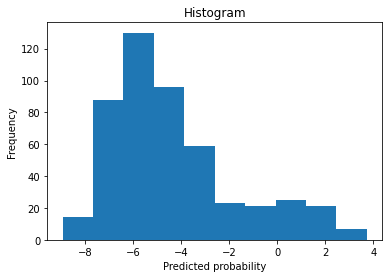

-2.1916468


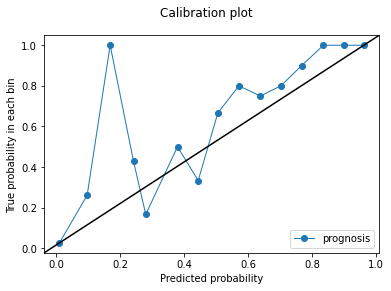

In [32]:
cutoffs['response'] = eval_outcome(output[output.split=='test'], 'response', cancer_type_list, graph=True)

In [38]:

for outcome in ['any_cancer','progression','response']:
    output[outcome+'_cutoff'] = cutoffs[outcome]
    output[outcome+'_prediction'] = np.where(output['cv_' + outcome + '_prediction'] >= output[outcome+'_cutoff'], 1, 0)




In [50]:
# curate full unlabeled data set
all_medonc_notes = pd.read_csv(prefix+'profile_2021/derived_data/curate_all/notes_with_neural_aps_found.csv')
all_medonc_notes['date'] = pd.to_datetime(all_medonc_notes.date)
all_medonc_notes['text'] = all_medonc_notes.ap_inferred

eval_medonc = all_medonc_notes[~all_medonc_notes.dfci_mrn.isin(label_analysis.dfci_mrn)]

In [51]:
eval_medonc.ap_split.value_counts()

validation    32654
test          30947
train_7       26709
train_0       26708
train_8       26334
train_5       25365
train_9       25233
train_4       25153
train_3       24707
train_6       24646
train_2       24596
train_1       23534
Name: ap_split, dtype: int64

In [52]:
# auto-annotate med onc notes across PROFILE

prediction_set = []

for subset in ['train_0','train_1','train_2','train_3','train_4','train_5','train_6','train_7','train_8','train_9','validation','test']:

    this_split = eval_medonc[eval_medonc.ap_split==subset]
    x_text = sequence.pad_sequences(tokenizer.texts_to_sequences([str(x) for x in this_split['text']]), maxlen=max_note_length, padding='post')


    for j in ['any_cancer', 'progression', 'response']:
        this_model = get_ensemble_model(j)
        this_split['cv_'+j+'_prediction'] = this_model.predict(x_text)

        this_split[j+'_cutoff'] = cutoffs[j]
        this_split[j+'_prediction'] = np.where(this_split['cv_' + j + '_prediction'] >= this_split[j+'_cutoff'], 1, 0)
        
        
    prediction_set.append(this_split)
    

In [53]:
unlabeled_curations = pd.concat(prediction_set, axis=0)

In [54]:
unlabeled_curations.split.value_counts()

train         252985
validation     32654
test           30947
Name: split, dtype: int64

In [58]:
labeled = output[['dfci_mrn','date','text','new_rx_30d','died_90d','died_180d','died_270d','died_360d','primary_cancer_diagnosis','genomics_date','after_profile','split','cv_any_cancer_prediction','cv_progression_prediction','cv_response_prediction', 'any_cancer_prediction','progression_prediction','response_prediction','any_cancer_cutoff','progression_cutoff','response_cutoff', 'any_cancer','progression','response','cancer_type']]
labeled['labeled'] = 1.

In [59]:
unlabeled = unlabeled_curations[['dfci_mrn','date','text','new_rx_30d','died_90d','died_180d','died_270d','died_360d','primary_cancer_diagnosis','genomics_date','after_profile','split','cv_any_cancer_prediction','cv_progression_prediction','cv_response_prediction', 'any_cancer_prediction','progression_prediction','response_prediction','any_cancer_cutoff','progression_cutoff','response_cutoff']]
unlabeled['labeled'] = 0.

In [60]:
final_output = pd.concat([labeled, unlabeled], axis=0).sort_values(by=['dfci_mrn','date']).reset_index(drop=True)

In [61]:
final_output.response.isnull().value_counts()

True     316586
False     32512
Name: response, dtype: int64

In [62]:
final_output.split.value_counts()

train         279745
validation     35588
test           33765
Name: split, dtype: int64

In [63]:
datafolder = prefix+'profile_2021/derived_data/curate_all/'

final_output.to_csv(datafolder+'all_medonc_curated'+extra_model_label+'.csv')